In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [5]:
import re, os, itertools, datetime
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile
from tqdm import tqdm

In [6]:
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, ReLU, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import regularizers
from sklearn import metrics as m

Using TensorFlow backend.


In [7]:
from PIL import Image
from skimage import transform

## 1. Data exploration

In [8]:
data_dir = "PlantVillage-Dataset/raw/color/"

In [9]:
classes = os.listdir(data_dir)
len(classes)

38

In [10]:
# check how balanced data set is (number of images in each class)

In [11]:
image_count = []
for c in classes:
    try: 
        path = data_dir + c
        count = len(os.listdir(path))
        image_count.append(count)
    except:
        pass

In [12]:
df_classes = pd.DataFrame.from_dict(dict(zip(classes, image_count)), orient="index")

In [13]:
num_classes = df_classes.shape[0]
num_classes

38

In [14]:
new_image_names = []
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        new_image_names.append(['{}/{}'.format(class_name, file), label, class_name])

In [15]:
df_images = pd.DataFrame(new_image_names, columns= ['file', 'label', 'class'])

In [16]:
df_images.head()

,file,label,class
0,Strawberry___healthy/8f558908-aa1b-4a86-855a-5...,0,Strawberry___healthy
1,Strawberry___healthy/b8e9ed27-8e37-4214-9206-f...,0,Strawberry___healthy
2,Strawberry___healthy/abdd34a0-ab02-41e0-95a3-a...,0,Strawberry___healthy
3,Strawberry___healthy/d1aee44a-b6bb-45b9-b7b6-5...,0,Strawberry___healthy
4,Strawberry___healthy/3d28c3ea-8419-4e09-addd-2...,0,Strawberry___healthy


## 1.2 Plotting images

In [17]:
def read_img(filepath, size):
    """Read & resize image and convert it into numpy array"""
    img = image.load_img(filepath, target_size = size)
    img = image.img_to_array(img)
    return img

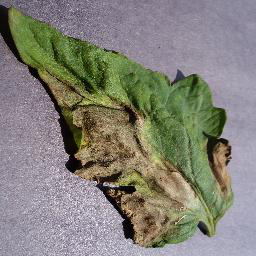

In [18]:
Image.fromarray(np.uint8(read_img(data_dir+df_images.iloc[8900][0], (256, 256))))

In [19]:
# plotting 10 images of each class

In [20]:
def format_name(n):
    return re.sub("_+", " ", n)

In [21]:
sum_classes = len(classes)

In [ ]:
fig = plt.figure(1, figsize=(10,40))
grid = ImageGrid(fig, 111, nrows_ncols = (sum_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in df_images["file"][df_images["class"] == class_name].values[:10]:
        ax = grid[i]
        img = read_img(data_dir+filepath, (256, 256))
        ax.imshow(img/255.)
        ax.axis('off')
        if i % 10 == 10 -1:
            name = format_name(filepath.split('/')[0])
            ax.text(260, 112, name, verticalalignment="center")
        i += 1
plt.show()
#plt.savefig('10leaves_of_each_class.png') 

In [ ]:
# plotting one image of each class with numeric label

In [ ]:
fig = plt.figure(1, figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 7), axes_pad=0.05)

for i in range(42):
    ax = grid[i]
    ax.axis('off')
    if i < len(classes):
        class_name = classes[i]
        for filepath in df_images["file"][df_images["class"] == class_name].values[:1]:
            img = read_img(data_dir+filepath, (256, 256))
            ax.imshow(img/255.)
            ax.annotate(i+1, xy=(10,25), color="black", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig('leaves_of_each_class_annotated.png')            

## 2. Train-test-split

In [ ]:
# create directory for train and test data and sub-directory for each class
tts_dir = "image_data_RGB_for_CNN/"
os.mkdir(tts_dir)
os.mkdir(tts_dir+'train')
os.mkdir(tts_dir+'test')
for c in classes:
    os.mkdir(tts_dir+"train/"+c)
    os.mkdir(tts_dir+"test/"+c)

In [22]:
num_images = len(df_images)

In [23]:
print(f'Number of images: {num_images}, Number of classes: {num_classes}')

Number of images: 54305, Number of classes: 38


In [24]:
train_size = 0.8
np.random.seed(50)
num = np.random.binomial(1,train_size,num_images)
len(num)

54305

In [ ]:
# copy images
i = 0
for file in tqdm(df_images['file'].values):
    from_path = data_dir + file
    if num[i] == 1:
        to_path = tts_dir + "train/" + file
    else:
        to_path = tts_dir + "test/" + file
    
    copyfile(from_path, to_path)
    i += 1

In [25]:
tts_dir = "image_data_RGB_for_CNN/"
train_dir = tts_dir + "train/"
test_dir = tts_dir + "test/"

In [26]:
df_data = []
for label, class_name in enumerate(classes):
    # train
    path = train_dir + class_name
    for file in os.listdir(train_dir):
        df_data.append(['{}/{}'.format(class_name, file), label, class_name, 1])
    # test
    path = test_dir + class_name
    for file in os.listdir(test_dir):
        df_data.append(['{}/{}'.format(class_name, file), label, class_name, 0])
        
df_data = pd.DataFrame(df_data, columns = ['file', 'label', 'class_name', 'train_id'])

In [27]:
num_train_samples = df_data.train_id.sum()
num_test_samples = len(df_data) - num_train_samples

print(f'Number of test images: {num_test_samples}')
print(f'Number of train images: {num_train_samples}')

Number of test images: 1444
Number of train images: 1444


In [28]:
df_data.tail()

,file,label,class_name,train_id
2883,Soybean___healthy/Apple___Black_rot,37,Soybean___healthy,0
2884,Soybean___healthy/Apple___healthy,37,Soybean___healthy,0
2885,Soybean___healthy/Strawberry___Leaf_scorch,37,Soybean___healthy,0
2886,Soybean___healthy/Potato___healthy,37,Soybean___healthy,0
2887,Soybean___healthy/Soybean___healthy,37,Soybean___healthy,0


## 3. Modeling
 - transfer learning using Inception V3
 - apply image augmentation to artificially increase data set (using ImageDataGenerator)

In [29]:
# specify data generator input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [30]:
# create data generators

width, height, depth = 299, 299, 3
batch = 64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=batch,
    shuffle=False)

Found 43616 images belonging to 38 classes.
Found 10689 images belonging to 38 classes.


In [31]:
# define model structure 
# - using transfer learning
# - from Inception v3 (trained on imagenet)
# - modifying last layer by adding new fully connected layer to base model

In [32]:
base_model = InceptionV3(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(rate=0.5)(x)
output = Dense(38, activation="softmax")(x)
model = Model(input=base_model.input, output=output)

In [33]:
# compile model:
# that defines the loss function, optimizer and metrics
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy")
#model.summary()

In [34]:
# can not use Accuracy as metric for inbalanced data set
# use F1_score, precision and recall
# get it via callback methode of Keras 
# source: https://github.com/keras-team/keras/issues/10472

In [35]:
class Metrics(Callback):
    
    def __init__(self, tr_data, val_data, batch_size = 50):
        super().__init__()
        self.train_data = tr_data
        self.validation_data = val_data
        self.batch_size = batch_size
    
    def on_train_begin(self, logs={}):
        #print(self.validation_data)
        self.tr_f1s = []
        self.tr_recalls = []
        self.tr_precisions = []
        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
            
            batch_tr = len(self.train_data)
            total_tr = batch_tr * self.batch_size

            tr_pred = []
            tr_true = []
            
            for batch in range(batch_tr):
                
                xtr, ytr = next(self.train_data)
                
                tr_pred_batch = np.zeros((len(xtr)))
                tr_true_batch = np.zeros((len(xtr)))

                tr_pred_batch = np.argmax(np.asarray(self.model.predict(xtr)), axis=1) 
                # incase of a binary or multiclass classification using softmax activation in the output layer and categorical_crossentropy loss
                tr_true_batch = np.argmax(ytr,axis=-1)
                
                tr_pred.append(tr_pred_batch)
                tr_true.append(tr_true_batch)

            tr_pred = np.asarray(list(itertools.chain.from_iterable(tr_pred)))
            tr_true = np.asarray(list(itertools.chain.from_iterable(tr_true)))
           
            _tr_f1 = m.f1_score(tr_true, tr_pred, average="weighted")
            _tr_precision = m.precision_score(tr_true, tr_pred, average="weighted")
            _tr_recall = m.recall_score(tr_true, tr_pred, average="weighted")

            self.tr_f1s.append(_tr_f1)
            self.tr_recalls.append(_tr_recall)
            self.tr_precisions.append(_tr_precision)
            
            logs['tr_f1s']= _tr_f1
            logs['tr_recall']= _tr_recall
            logs['tr_precision']= _tr_precision
            
            print("- tr_f1: {} - tr_recall: {} - tr_precision {}".format(
                _tr_f1, _tr_recall, _tr_precision))
            
            batches = len(self.validation_data)
            total = batches * self.batch_size
            
            val_pred = []
            val_true = []

            for batch in range(batches):
                
                xVal, yVal = next(self.validation_data)
                
                val_pred_batch = np.zeros((len(xVal)))
                val_true_batch = np.zeros((len(xVal)))

                val_pred_batch = np.argmax(np.asarray(self.model.predict(xVal)), axis=-1) 
                # incase of a binary or multiclass classification using softmax activation in the output layer and categorical_crossentropy loss
                val_true_batch = np.argmax(yVal,axis=-1)
                
                val_pred.append(val_pred_batch)
                val_true.append(val_true_batch)

            val_pred = np.asarray(list(itertools.chain.from_iterable(val_pred)))
            val_true = np.asarray(list(itertools.chain.from_iterable(val_true)))

            _val_f1 = m.f1_score(val_true, val_pred, average = "weighted")
            _val_precision = m.precision_score(val_true, val_pred, average = "weighted")
            _val_recall = m.recall_score(val_true, val_pred, average = "weighted")

            self.val_f1s.append(_val_f1)
            self.val_recalls.append(_val_recall)
            self.val_precisions.append(_val_precision)
            
            logs['val_f1s']= _val_f1
            logs['val_recall']= _val_recall
            logs['val_precision']= _val_precision
            
            print("- val_f1: {} - val_recall: {} - val_precision {}".format(
                _val_f1, _val_recall, _val_precision))
            
            return

In [36]:
metric = Metrics(train_generator, test_generator, batch_size = 64)

In [37]:
# Visualize graph and other tools with Tensorboard interface
# - to understand, debug and optimize the model
# source: https://github.com/tensorflow/tensorboard/blob/master/docs/r1/summaries.md

In [38]:
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
tensor = TensorBoard(log_dir = log_dir)

In [39]:
# Define Checkpoints to save weights during training
# - use ModelCheckpoint callback class
# - define checkpoint circumstances and file name

In [40]:
path ="inception_v3"+".hdf5"
checkpoint = ModelCheckpoint(path,
                            monitor="val_loss",
                            mode="min",
                            verbose=1,
                            save_best_only=True)

In [41]:
# monitor quality of improvment
# - use ReduceLROnPlateau callback function
# - reduces learning rate if no improvment is made for a "patience" num. of epochs

In [42]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                             factor=0.2,
                             patience=4,
                             cooldown=5)

In [43]:
filepath = "inception_v3"+".csv"
csv_log = CSVLogger(filepath)

In [ ]:
# fit transfer learning model
history = model.fit_generator(
    train_generator, 
    epochs=5,
    steps_per_epoch=50,
    validation_data=test_generator,
    validation_steps=180,
    callbacks=[checkpoint, reduce_lr, csv_log, metric])
    #callbacks=[metric, checkpoint, reduce_lr, csv_log, tensor])

Epoch 1/5
50/50 [==============================] - 1762s 35s/step - loss: 1.8011 - val_loss: 3.3725

Epoch 00001: val_loss improved from inf to 3.37246, saving model to inception_v3.hdf5
- tr_f1: 0.03062362151405805 - tr_recall: 0.04512105649303008 - tr_precision 0.08116667638023858
- val_f1: 0.05069315038061369 - val_recall: 0.060435962204135094 - val_precision 0.09228889637742275
Epoch 2/5
50/50 [==============================] - 1755s 35s/step - loss: 0.8789 - val_loss: 0.9204

Epoch 00002: val_loss improved from 3.37246 to 0.92043, saving model to inception_v3.hdf5
- tr_f1: 0.19419963434651638 - tr_recall: 0.2643066764490095 - tr_precision 0.3681285902496016
- val_f1: 0.1931029524820842 - val_recall: 0.27383291233978857 - val_precision 0.2868068769668911
Epoch 3/5
50/50 [==============================] - 1751s 35s/step - loss: 0.7054 - val_loss: 0.0752

Epoch 00003: val_loss improved from 0.92043 to 0.07519, saving model to inception_v3.hdf5
- tr_f1: 0.1988295179699126 - tr_recall:

In [1]:
# plotting train and test loss
df_history = pd.DataFrame(history.history)
df_history['val_f1'] = metric.val_f1s
df_history['val_precision'] = metric.val_precisions
df_history['val_recall'] = metric.val_recalls
df_history[['loss', 'val_loss']].plot()
df_history[['val_f1', 'val_precision', 'val_recall']].plot()

NameError: name 'pd' is not defined

## 4. Prediction
 - using saved model & weights
 - Reset! test_generator before using predict_generator to avoid random output

In [45]:
test_generator.reset()
predictions = model.predict_generator(generator=test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes

In [46]:
# sanity check
print("Precision_weighted:", m.precision_score(y_test, y_pred, average="weighted")*100)
print("Recall_weighted:", m.recall_score(y_test, y_pred, average="weighted")*100)
print("F1_weighted:", m.f1_score(y_test, y_pred, average="weighted")*100)

Precision_weighted: 0.895322127468578
Recall_weighted: 2.151744784357751
F1_weighted: 0.5917561047154077


In [ ]:
# map predicted labels to unique ids (filenames)
labels_map = train_generator.class_indices
labels = dict((v, k) for k, v in labels_map.items())
predict = [labels[k] for k in y_pred]

# store results in dataframe
filenames = test_generator.filenames
results = pd.DataFrame({"Filenames": filenames, "Prediction": predict})

In [ ]:
# Visualize precision-racall confusion matrix
# 1. Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_consusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    print("Number of misclassified images-", (len(test_y)-np.trace(C)))
    print("% of misclassified images-", (len(test_y)-np.trace(C))*100/len(test_y))
    
    labels = [i for i in range(1,38)]
    cmap = sns.light_platte("blue")
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize = (25, 12))
    sns.heatmap(C, annot=True, cmap = cmap, fmt = ".1f", xticklabls = labels, ytricklabels = labels)
    plt.xlabels("Predicted Classes")
    plt.ylabels("Original Classes")
    plt.show()

In [ ]:
plot_confusion_matrix(y_test, y_pred)

Result:
 - some images from class 7 get predicted as class 9 and vice versa
 - class 32 is predicted as class 30
 - class 34 is predicted as 33, 37 

In [ ]:
# 2. Recall matrix
def plot_recall_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    
    labels = [i for i in range(1,38)]
    cmap = sns.light_platte("green")
    print("-"*50, "Recall matrix", "-"*50)
    plt.figure(figsize = (25, 12))
    sns.heatmap(A, annot=True, cmap = cmap, fmt = ".2f", xticklabls = labels, ytricklabels = labels)
    plt.xlabels("Predicted Classes")
    plt.ylabels("Original Classes")
    plt.show()
    print("Sum of rows in recall matrix", A.sum(axis=1))

In [ ]:
plot_recall_matrix(y_test, y_pred)

Result:
 - recall for class 7, 9 is not as good as compared to others

In [ ]:
# 3. Precision matrix
def plot_precision_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    B = (C/C.sum(axis=1))
    
    labels = [i for i in range(1,38)]
    cmap = sns.light_platte("red")
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize = (25, 12))
    sns.heatmap(B, annot=True, cmap = cmap, fmt = ".2f", xticklabls = labels, ytricklabels = labels)
    plt.xlabels("Predicted Classes")
    plt.ylabels("Original Classes")
    plt.show()
    print("Sum of columns in precision matrix", B.sum(axis=0))

In [ ]:
plot_precision_matrix(y_test, y_pred)

Result:
 - precision for classes 7, 9, 29, 30 is not as good compared to others

## 5. Prediction on Images
 - define function to predict class for a single image, plot the result and the image

In [ ]:
def plant_diagnosis(file):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float23')/255
    np_image = transform.resize(np_image, (299, 299, 3))
    image = np.expand_dims(np_image, axis=0)
    pred = inc_model.predict(image)
    k = np.argmax(pred, axis = 1)
    clas = labels[k[0]]
    plt.imshow(plt.imread(file))
    plt.title("diagnosis: "+str(clas))
    plt.show()

In [ ]:
plant_diagnosis("/Users/pepper/PythonProjects/plant_diagnosis/PlantVillage-Dataset/raw/color/Pepper,_bell___Bacterial_spot/0c99cb45-b4e0-4ade-bba5-fab3b678f0bb___JR_B.Spot 8912.JPG")

In [ ]:
plant_diagnosis("/Users/pepper/PythonProjects/plant_diagnosis/PlantVillage-Dataset/raw/color/Orange___Haunglongbing_(Citrus_greening)/0a5026a4-68e9-4cd9-8510-5bdb9d0271f9___UF.Citrus_HLB_Lab 0893.JPG")